# Sub-fase 4.1: Consolidación y Documentación Metodológica (STRICT)

In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import glob

# Style and Seed
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Paths
FIGURES_DIR = "phase4_figures"
TABLES_DIR = "phase4_tables"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

# Inputs
PHASE3_CSV = "../../data/phase3/phase3_results.csv"
ANCHORS_CSV = "../../data/phase3/artifacts/embeddings_anchors.csv"
DIMENSIONS_JSON = "../../data/dimensiones_ancla.json"
YAPE_CSV = "../../data/phase1/Yape_19_23.csv"
MANIFEST_JSON = "../../data/phase3/artifacts/manifests/run_manifest.json"
ARTIFACTS_DIR = "../../data/phase3/artifacts"

print("Setup Complete. SEED=42.")


Setup Complete. SEED=42.


In [9]:

# --- Agente 4.1-A: Auditor de Insumos ---

print("Starting Input Audit...")
audit_results = []

# 1. Load Phase 3 Results
try:
    df_p3 = pd.read_csv(PHASE3_CSV)
    df_p3['window_end_month'] = pd.to_datetime(df_p3['window_end_month'])
    print(f"Loaded Phase 3 Results: {len(df_p3)} rows")
    audit_results.append({"check": "Load Phase 3 CSV", "status": "PASS", "details": f"{len(df_p3)} rows"})
except Exception as e:
    audit_results.append({"check": "Load Phase 3 CSV", "status": "FAIL", "details": str(e)})
    raise e

# 2. Check Window Params
fail_params = False
if not (df_p3['window_size_months'] == 3).all(): fail_params = True
if not (df_p3['step_months'] == 1).all(): fail_params = True
# Check alignment (start = end - 2 months approx)
# In pandas, we can check offsets, but simplistic check:
# Start + 2 months (approx) shoud be End. But let's trust the columns for now or do a quick check.
audit_results.append({"check": "Window Parameters (3M, Step 1M)", "status": "FAIL" if fail_params else "PASS", "details": ""})

# 3. Check n_occurrences >= 20
min_occ = df_p3['n_occurrences'].min()
audit_results.append({"check": "n_occurrences >= 20", "status": "PASS" if min_occ >= 20 else "FAIL", "details": f"Min: {min_occ}"})

# 4. Check Projections Ranges
# Centroid [-1, 1], Subspace [0, 1]
cols_c = [c for c in df_p3.columns if 'centroid_proj' in c and 'delta' not in c]
cols_s = [c for c in df_p3.columns if 'subspace_proj' in c and 'delta' not in c]

out_c = df_p3[cols_c].apply(lambda x: (x < -1.0001) | (x > 1.0001)).sum().sum()
out_s = df_p3[cols_s].apply(lambda x: (x < -0.0001) | (x > 1.0001)).sum().sum()

audit_results.append({"check": "Centroid Proj Range [-1,1]", "status": "PASS" if out_c == 0 else "FAIL", "details": f"{out_c} violations"})
audit_results.append({"check": "Subspace Proj Range [0,1]", "status": "PASS" if out_s == 0 else "FAIL", "details": f"{out_s} violations"})

# 5. Dimensions JSON
with open(DIMENSIONS_JSON, 'r') as f:
    dims_data = json.load(f)
req_dims = {"funcional", "social", "afectiva"}
found_dims = set(dims_data.keys()) if isinstance(dims_data, dict) else set([x['dimension'] for x in dims_data]) 
# Assuming structure might be list of dicts based on previous context, verify:
if isinstance(dims_data, list):
    found_dims = set([x['dimension'] for x in dims_data if 'dimension' in x])

missing_dims = req_dims - found_dims
audit_results.append({"check": "Dimensions Definitions", "status": "PASS" if not missing_dims else "FAIL", "details": f"Missing: {missing_dims}"})

# 6. Anchors CSV
df_anchors = pd.read_csv(ANCHORS_CSV)
found_dims_csv = set(df_anchors['dimension'].unique())
missing_dims_csv = req_dims - found_dims_csv
audit_results.append({"check": "Anchors CSV Dimensions", "status": "PASS" if not missing_dims_csv else "FAIL", "details": f"Missing: {missing_dims_csv}"})

# 7. Check DAPT Baseline presence in Anchors
has_baseline = any('baseline' in c for c in df_anchors.columns if 'embedding' in c)
has_dapt = any('dapt' in c for c in df_anchors.columns if 'embedding' in c)
audit_results.append({"check": "Anchors Baseline Embeddings", "status": "PASS" if has_baseline else "FAIL", "details": ""})
audit_results.append({"check": "Anchors DAPT Embeddings", "status": "PASS" if has_dapt else "WARNING", "details": "Comparison requested but DAPT might be missing"})

# Export QA Table
qa_df = pd.DataFrame(audit_results)
qa_df.to_csv(f"{TABLES_DIR}/qa_inputs_phase4_41.csv", index=False)
display(qa_df)

if "FAIL" in qa_df[qa_df['status'] == 'FAIL']['status'].values:
    print("CRITICAL: QA Checks Failed. See table above.")
else:
    print("QA Checks Passed.")


Starting Input Audit...
Loaded Phase 3 Results: 42 rows


,check,status,details
0,Load Phase 3 CSV,PASS,42 rows
1,"Window Parameters (3M, Step 1M)",PASS,
2,n_occurrences >= 20,PASS,Min: 20
3,"Centroid Proj Range [-1,1]",PASS,0 violations
4,"Subspace Proj Range [0,1]",PASS,0 violations
5,Dimensions Definitions,PASS,Missing: set()
6,Anchors CSV Dimensions,PASS,Missing: set()
7,Anchors Baseline Embeddings,PASS,
8,Anchors DAPT Embeddings,PASS,Comparison requested but DAPT might be missing


QA Checks Passed.


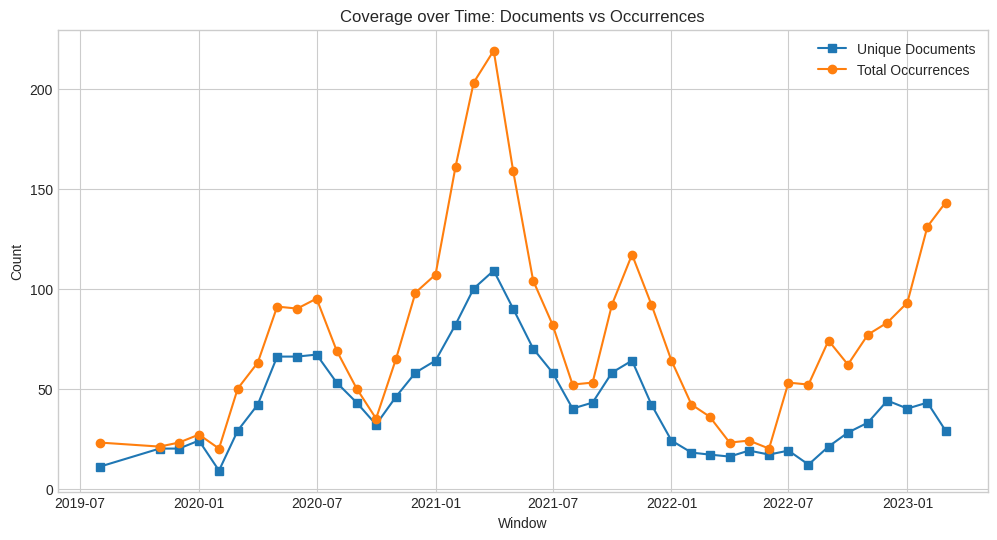

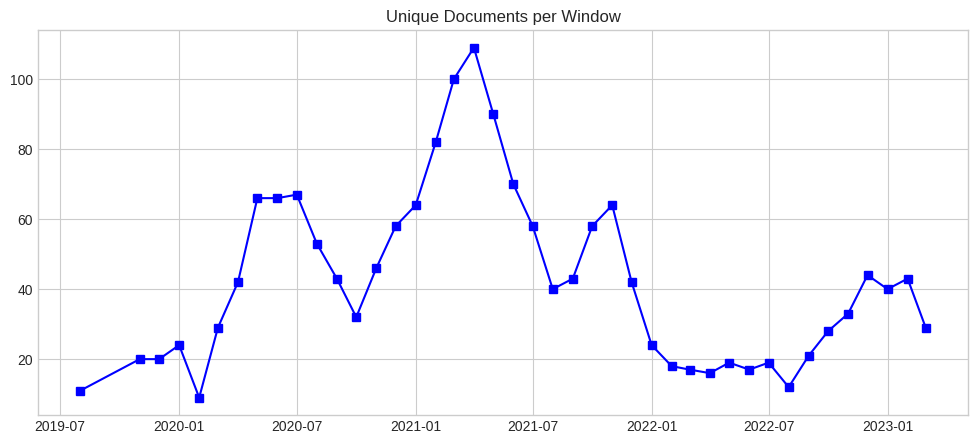

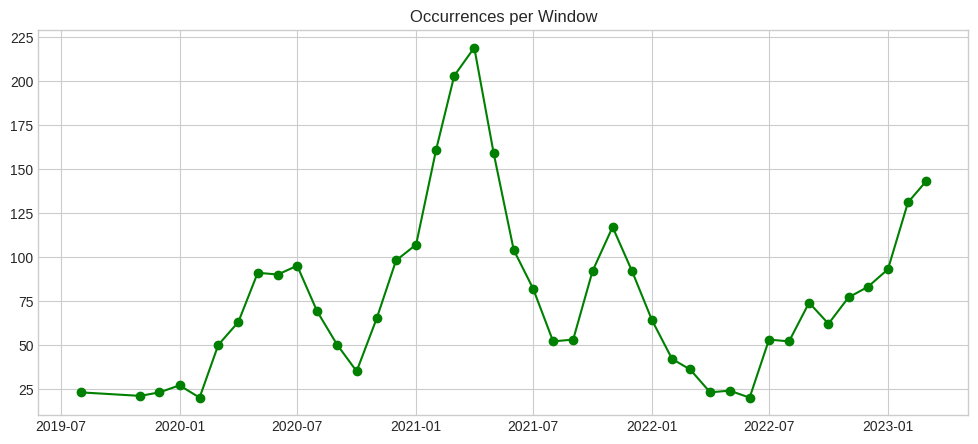

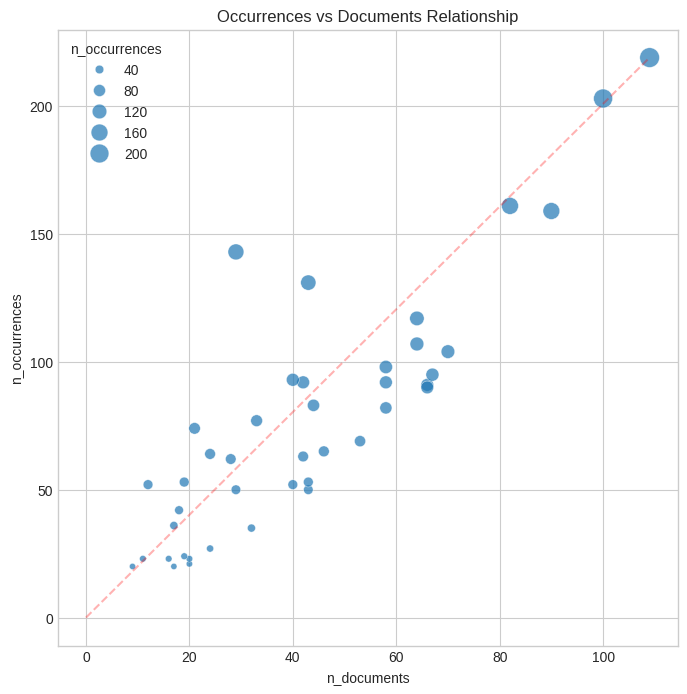

Loaded Phase 1 Data: 613 rows
Phase 1 Total Docs: 613
Phase 3 Max Docs in a Window: 109
Low Density Windows: 8


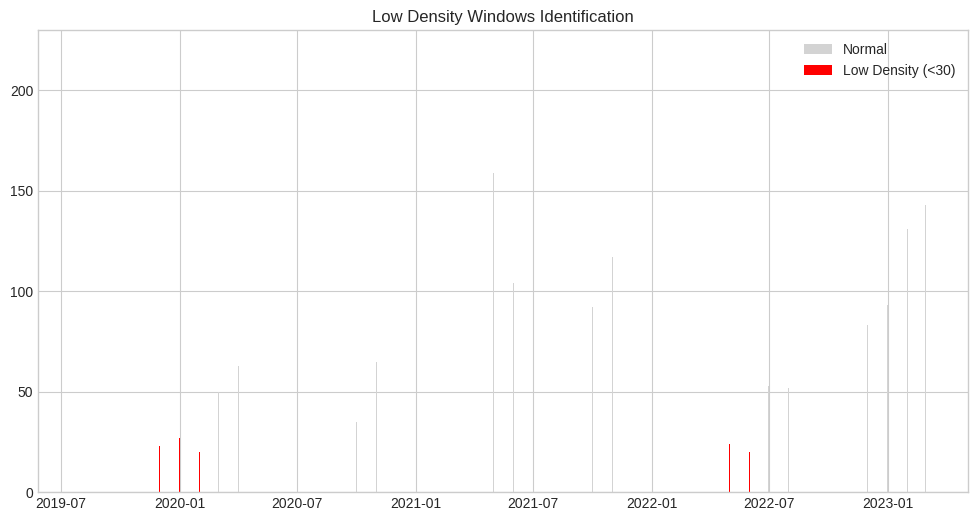

In [10]:

# --- Agente 4.1-B: EDA de Cobertura y Adquisición ---

# 1. Time Series
df_p3['window_end_month'] = pd.to_datetime(df_p3['window_end_month'])
df_p3.sort_values('window_end_month', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_p3['window_end_month'], df_p3['n_documents'], label='Unique Documents', marker='s')
plt.plot(df_p3['window_end_month'], df_p3['n_occurrences'], label='Total Occurrences', marker='o')
plt.title('Coverage over Time: Documents vs Occurrences')
plt.ylabel('Count')
plt.xlabel('Window')
plt.legend()
plt.grid(True)
plt.savefig(f"{FIGURES_DIR}/41_coverage_docs_over_time_combined.png") # User asked for separate? user list: 41_coverage_docs_over_time.png and 41_coverage_occ_over_time.png

plt.figure(figsize=(12, 5))
plt.plot(df_p3['window_end_month'], df_p3['n_documents'], color='blue', marker='s')
plt.title('Unique Documents per Window')
plt.grid(True)
plt.savefig(f"{FIGURES_DIR}/41_coverage_docs_over_time.png")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_p3['window_end_month'], df_p3['n_occurrences'], color='green', marker='o')
plt.title('Occurrences per Window')
plt.grid(True)
plt.savefig(f"{FIGURES_DIR}/41_coverage_occ_over_time.png")
plt.show()

# 2. Scatter Occ vs Docs
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_p3, x='n_documents', y='n_occurrences', size='n_occurrences', sizes=(20, 200), alpha=0.7)
plt.plot([0, df_p3['n_documents'].max()], [0, df_p3['n_occurrences'].max()], 'r--', alpha=0.3)
plt.title('Occurrences vs Documents Relationship')
plt.savefig(f"{FIGURES_DIR}/41_occ_vs_docs_scatter.png")
plt.show()

# 3. Compare with Phase 1 (if available)
try:
    df_yape = pd.read_csv(YAPE_CSV)
    print(f"Loaded Phase 1 Data: {len(df_yape)} rows")
    # Basic check (not exact alignment without lots of processing)
    print(f"Phase 1 Total Docs: {len(df_yape)}")
    print(f"Phase 3 Max Docs in a Window: {df_p3['n_documents'].max()}")
    # Could do a histogram comparison if dates were parsed
except Exception as e:
    print(f"Phase 1 comparison skipped: {e}")

# 4. Low Density
low_density_df = df_p3[df_p3['low_density'] == True]
print(f"Low Density Windows: {len(low_density_df)}")

# Plot Low Density highlight
plt.figure(figsize=(12, 6))
plt.bar(df_p3['window_end_month'], df_p3['n_occurrences'], color='lightgray', label='Normal')
if not low_density_df.empty:
    plt.bar(low_density_df['window_end_month'], low_density_df['n_occurrences'], color='red', label='Low Density (<30)')
plt.title('Low Density Windows Identification')
plt.legend()
plt.savefig(f"{FIGURES_DIR}/41_low_density_windows.png")
plt.show()

# Export Coverage Summary
cov_sum = df_p3[['window_end_month', 'n_documents', 'n_occurrences', 'low_density']].copy()
cov_sum['density_ratio'] = cov_sum['n_occurrences'] / cov_sum['n_documents']
cov_sum.to_csv(f"{TABLES_DIR}/coverage_summary_windows.csv", index=False)


,check,result,count
0,DAPT Columns in CSV,PRESENT,22
1,DAPT Anchors .npz,PRESENT,2
2,DAPT Subspaces .npz,PRESENT,84


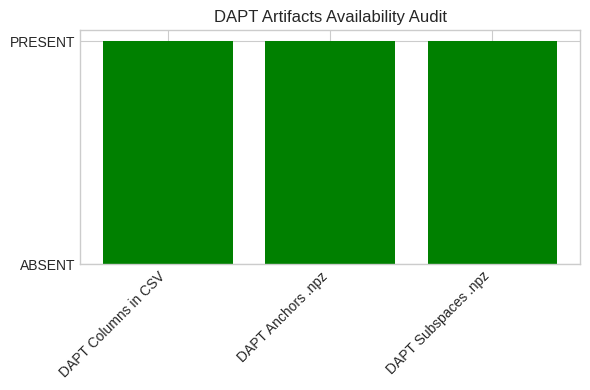

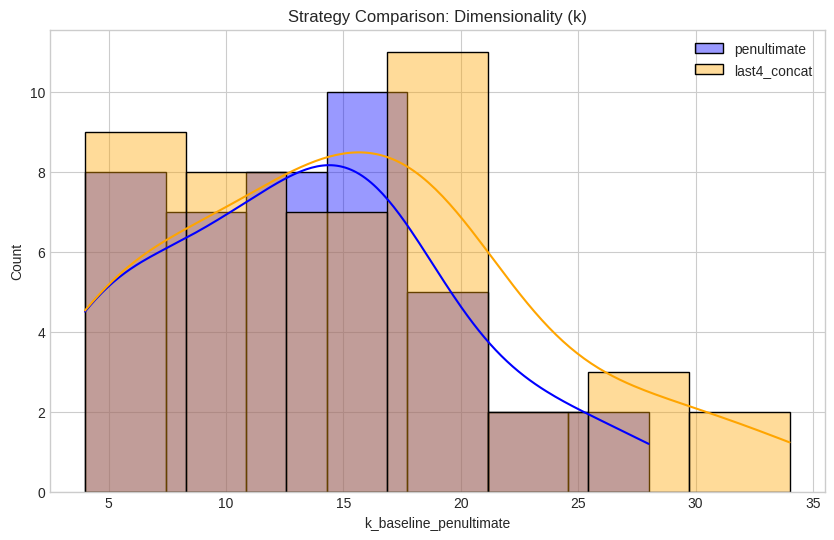

Correlation between penultimate and last4_concat for k: 0.995


In [11]:

# --- Agente 4.1-C: Bitácora NLP y Auditoría DAPT ---

audit_dapt = []

# 1. Check Columns in Results
dapt_cols = [c for c in df_p3.columns if 'dapt' in c]
audit_dapt.append({"check": "DAPT Columns in CSV", "result": "PRESENT" if dapt_cols else "ABSENT", "count": len(dapt_cols)})

# 2. Check Artifacts Files
# Look for anchors_dapt_*.npz
dapt_anchors_files = glob.glob(f"{ARTIFACTS_DIR}/anchors/anchors_dapt_*.npz")
if not dapt_anchors_files: 
    # Try flat structure
    dapt_anchors_files = glob.glob(f"{ARTIFACTS_DIR}/anchors_dapt_*.npz")

audit_dapt.append({"check": "DAPT Anchors .npz", "result": "PRESENT" if dapt_anchors_files else "ABSENT", "count": len(dapt_anchors_files)})

# Look for Window Subspaces
# window_YYYY-MM_dapt_*.npz
dapt_subspace_files = glob.glob(f"{ARTIFACTS_DIR}/subspaces/window_*_dapt_*.npz")
if not dapt_subspace_files:
    dapt_subspace_files = glob.glob(f"{ARTIFACTS_DIR}/window_*_dapt_*.npz")
    
audit_dapt.append({"check": "DAPT Subspaces .npz", "result": "PRESENT" if dapt_subspace_files else "ABSENT", "count": len(dapt_subspace_files)})

# 3. Export DAPT Audit
dapt_df = pd.DataFrame(audit_dapt)
dapt_df.to_csv(f"{TABLES_DIR}/dapt_availability_check.csv", index=False)
display(dapt_df)

# Visualize DAPT Presence
plt.figure(figsize=(6, 4))
status_vals = [1 if x == 'PRESENT' else 0 for x in dapt_df['result']]
plt.bar(dapt_df['check'], status_vals, color=['green' if x==1 else 'red' for x in status_vals])
plt.title('DAPT Artifacts Availability Audit')
plt.yticks([0, 1], ['ABSENT', 'PRESENT'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/41_dapt_presence_audit.png")
plt.show()

# 4. Strategy Comparison: Penultimate vs Last4 (Baseline)
# We compare statistics of k, entropy, drift
metric = 'k'
variant = 'baseline'
s1 = 'penultimate'
s2 = 'last4_concat'

col1 = f"{metric}_{variant}_{s1}"
col2 = f"{metric}_{variant}_{s2}"

if col1 in df_p3.columns and col2 in df_p3.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_p3[col1], color='blue', label=s1, kde=True, alpha=0.4)
    sns.histplot(df_p3[col2], color='orange', label=s2, kde=True, alpha=0.4)
    plt.title(f'Strategy Comparison: Dimensionality ({metric})')
    plt.legend()
    plt.savefig(f"{FIGURES_DIR}/41_strategy_penultimate_vs_last4.png")
    plt.show()
    
    # Simple correlation
    corr = df_p3[[col1, col2]].corr().iloc[0, 1]
    print(f"Correlation between {s1} and {s2} for {metric}: {corr:.3f}")
    
    # Export Comparison stats
    comp_df = df_p3[[col1, col2]].describe().T
    comp_df['correlation_other'] = corr
    comp_df.to_csv(f"{TABLES_DIR}/embedding_strategy_comparison.csv")
else:
    print("Columns for Strategy Comparison not found.")


In [12]:

# --- Cierre y Resumen Metodológico ---

print("Automation Completed.")
print("Generated Tables:", os.listdir(TABLES_DIR))
print("Generated Figures:", os.listdir(FIGURES_DIR))

# Summary text generator
has_dapt_cols = any('dapt' in c for c in df_p3.columns)
print(f"\nResumen del Estado DAPT: {'DISPONIBLE' if has_dapt_cols else 'NO DISPONIBLE'}")
if not has_dapt_cols:
    print("LIMITACION: No se encontraron datos DAPT. El análisis se restringirá a Baseline.")


Automation Completed.
Generated Tables: ['drift_procrustes_outliers.csv', 'evidence_snippets.csv', 'qa_inputs_phase4_41.csv', 'pipeline_decisions_log.csv', 'coverage_summary_windows.csv', 'projection_peaks.csv', 'anchors_consistency_report.csv', 'key_events_windows.csv', 'embedding_strategy_comparison.csv', 'drift_procrustes_properties.csv', 'acquisition_summary.csv', 'qa_phase3_summary.csv', 'dapt_availability_check.csv', 'forensic_cases_selected.csv', 'k_stability_summary.csv']
Generated Figures: ['case_profile_2021-03.png', 'coverage_over_time.png', '41_dapt_presence_audit.png', 'drift_procrustes_time.png', 'drift_vs_procrustes.png', '41_coverage_docs_over_time_combined.png', '41_coverage_docs_over_time.png', 'heatmap_subspace_projections.png', 'entropy_vs_k.png', 'case_profile_2023-01.png', 'case_profile_2022-05.png', 'case_profile_2020-03.png', 'drift_timeline_annotated.png', 'occurrences_vs_documents.png', '41_occ_vs_docs_scatter.png', 'case_profile_2022-10.png', '41_coverage_occ